# Set Up the Data
When this Binder environment was initialized, the supplemental data from [Optimal Decoding of Cellular Identities in a Genetic Network](https://doi.org/10.1016/j.cell.2019.01.007) is downloaded, and its extracted contents appear in the `Data` directory. 

For now, we are interested in the wild-type gap gene data in `Data/Data/Gap/gap_data_raw_dorsal_wt.mat`. This contains semi-quantitative raw data of the four gap genes (Hb, Kr, Kni, and Gt) during nuclear cycle 14 in 102 drosophila embryos. It is stored as a MATLAB struct array. This is a somewhat complex data structure with no convenient parallel in Python, so we will spend a moment exploring how to access its contents.

In [1]:
%matplotlib inline
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
#mat = scipy.io.loadmat('Data/Data/Gap/gap_data_raw_dorsal_wt.mat')
mat = scipy.io.loadmat('gap_data_raw_dorsal_wt.mat')

Let's see how this data is formatted ...

In [2]:
type(mat)

dict

It's loaded as a dict, so let's see what it contains.


In [3]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'data'])

The `'__header__'`, `'__version__'`, and `'__globals__'` keys are unimportant metadata. Let's see what is inside `'data'`.


In [4]:
type(mat['data'])

numpy.ndarray

It's a [`numpy.ndarray`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) object, so we can use those attributes to explore what's inside. Let's start with [`dtype`](https://numpy.org/doc/stable/reference/generated/numpy.dtype.html#numpy.dtype) and its attributes to get a better idea of the contents.

In [5]:
mat['data'].dtype
# 'Kni', 'Kr', 'Gt', 'Hb'

dtype([('index', 'O'), ('orient', 'O'), ('dist', 'O'), ('age', 'O'), ('genotype', 'O'), ('Kni', 'O'), ('Kr', 'O'), ('Gt', 'O'), ('Hb', 'O')])

This indicates there are multiple objects (`'O'`) within the `mat['data']` `numpy.ndarray` object. The readme file associated with the data states: 

>DATA DESCRIPTION:
>
Every .mat file contains a data structure with the following fields: 
>
.index = embryo # on the slide (for internal purposes) 
.orient = 1 or 2, corresponding to dorsal and ventral orientation, respectively. 
.dist = depth of the furrow canal, in microns
.age =  embryo age in minutes after the start of nc14
.gene_name  =  raw fluorescence gene expression profiles taken along the dorsal side of the embryo.
Each profile vector is of length 1000 pixels, where 0 corresponds to the anterior (A) and 1000 to the posterior (P) of the embryo.   

In [6]:
type(mat['data']['Kni'])

numpy.ndarray

In [7]:
mat['data']['Kni'].shape

(1, 102)

In [8]:
type(mat['data']['Kni'][0])

numpy.ndarray

In [9]:
mat['data']['Kni'][0].shape

(102,)

In [10]:
type(mat['data']['Kni'][0][0])

numpy.ndarray

In [11]:
mat['data']['Kni'][0][0].shape

(1, 1000)

In [12]:
type(mat['data']['Kni'][0][0][0])

numpy.ndarray

In [13]:
mat['data']['Kni'][0][0][0].shape

(1000,)

In [14]:
type(mat['data']['Kni'][0][0][0][0])

numpy.float64

This shows that each data point is part of a 1000-pixel-long profile, of which there are 102 for each gene, as described in the readme file. We can extract this into a more useable format through a nested [list comprehension](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions).

In [15]:
kni_raw = [pixel for profile in mat['data']['Kni'][0][:] for pixel in profile]
kr_raw = [pixel for profile in mat['data']['Kr'][0][:] for pixel in profile]
gt_raw = [pixel for profile in mat['data']['Gt'][0][:] for pixel in profile]
hb_raw = [pixel for profile in mat['data']['Hb'][0][:] for pixel in profile]

raw_data = np.transpose(np.array([kni_raw, kr_raw, gt_raw, hb_raw]))
raw_data.shape

(1000, 102, 4)

This array now has the demensions pixels x embryos x genes.

Authors' description of the data: 
>Each profile vector is of length 1000
pixels, where 0 corresponds to the anterior (A) and 1000 to the posterior (P) of the embryo.

To mitigate 'edge effects,' we extract only the middle 80% of the data to use throughout the analysis.

We will also use only a fraction of the embryos for illustration to speed up the calculations.

In [16]:
from anchormean0to1 import *
from aligny import *
from alignxy import *

(n_pixels, n_embryos, n_genes) = raw_data.shape

# Use a subset to speed examples.
n_embryos_used = round(n_embryos/10) 
idcs = np.sort(np.random.permutation(np.random.randint(1, n_embryos,size=n_embryos_used)))
Y_raw = raw_data.astype(float)

# Restrict profiles to middle 80%
x = (np.arange(1/n_pixels, 1, 1/n_pixels)) 
idx_low = int(np.dot(round(n_pixels),0.1))
idx_high = int(np.dot(round(n_pixels),0.9))
x = x[idx_low:idx_high]

Y_raw = Y_raw[idx_low:idx_high,idcs,:]
####pad_size = round((n_pixels*0.1))
####Y_raw = np.pad(Y_raw,[(pad_size,pad_size),(0,0),(0,0)],mode='constant', constant_values=(np.nan))


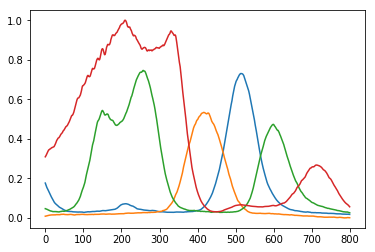

In [130]:
def anchormean0to1(Y):
    
    """Anchor the mean of a profile set from 0 to 1.
    
    Input:
      > Y: profiles to anchor (nPts x nSamples x nTargets).
    
    Output:
      > Y_anchor: profiles scaled such that the mean ranges from 0 to 1.
      > Y_mean: mean profile, min = 0 and max = 1.
    """
    
    
    Y_mean = np.nanmean(Y,axis=1)
    Y_anchor = ((Y - np.nanmin(Y_mean,axis=0))/((np.nanmax(Y_mean,axis=0)) - (np.nanmin(Y_mean,axis=0))))    
    Y_mean = np.nanmean(Y_anchor,axis=1)
    
    return Y_anchor,Y_mean

plt.plot(Y_anchor)

In [126]:
Y_mean = np.nanmean(Y_raw,axis=1)
mins = np.nanmin(Y_mean,axis=0)
mins

array([ 99.33484044,  72.65733663, 111.83129583, 118.3097415 ])

In [89]:
np.max(Y_mean[:,0])

0.730483890468259

In [84]:
Y_mean = np.nanmean(Y_raw,axis=1) #"in" plot for Hb
for gene in range(0,n_genes):
    Y_anchor,Y_mean = anchormean0to1(Y_raw[:,gene])
    plt.plot(x,Y_mean

plt.show()


for embryo in np.arange(1,n_embryos_used): 
    plt.plot(x,Y_raw[:,embryo,0],color='grey', linewidth=0.5)
plt.plot(x,Y_mean[:,0],color='black')
plt.title('Raw Data In')
plt.show()


#for i in np.arange(1,102): 
#   plt.plot(Y_anchor[:,i,0],color='grey', linewidth=0.5)
   
#plt.plot(Y_mean[:,0],color='black')
#plt.title('Python out')
#plt.show()

SyntaxError: invalid syntax (<ipython-input-84-ffaca2753d0f>, line 6)